In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('sample_detect_outliers.csv')

In [3]:
df.head()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
0,1004,1.716172,1.300330,6.953107,0.007855,0,0.036106,0.362751,1
1,1004,1.664240,1.802926,6.736387,0.007212,0,0.021635,0.359671,1
2,1004,1.163486,1.595639,7.090351,0.006781,0,0.006848,0.354971,1
3,1004,1.416672,1.147767,7.346950,0.006755,0,0.027284,0.210000,1
4,1050,0.626734,0.659966,5.562565,0.013321,1,0.065985,0.350000,0


In [4]:

# (Number of entries, Number of features)
df.shape

(6279, 9)

In [5]:
df.describe()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
count,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000
mean,57841.428094,1.951751,1.778861,7.625380,0.016864,0.236184,0.196037,0.255268,0.821628
std,66106.400906,3.091940,2.695251,1.731492,0.029755,0.424770,0.223529,0.117834,0.382856
min,1004.000000,0.000000,0.032784,3.607576,0.000000,0.000000,0.000571,0.000000,0.000000
25%,10221.000000,0.485310,0.452138,6.441416,0.000000,0.000000,0.038528,0.210000,1.000000
50%,24171.000000,0.919717,0.845846,7.535678,0.000000,0.000000,0.109758,0.338186,1.000000
75%,116166.000000,1.951153,1.801071,8.730227,0.022831,0.000000,0.262504,0.350000,1.000000
max,315318.000000,34.634146,15.867922,12.190620,0.203976,1.000000,0.960804,0.380506,1.000000


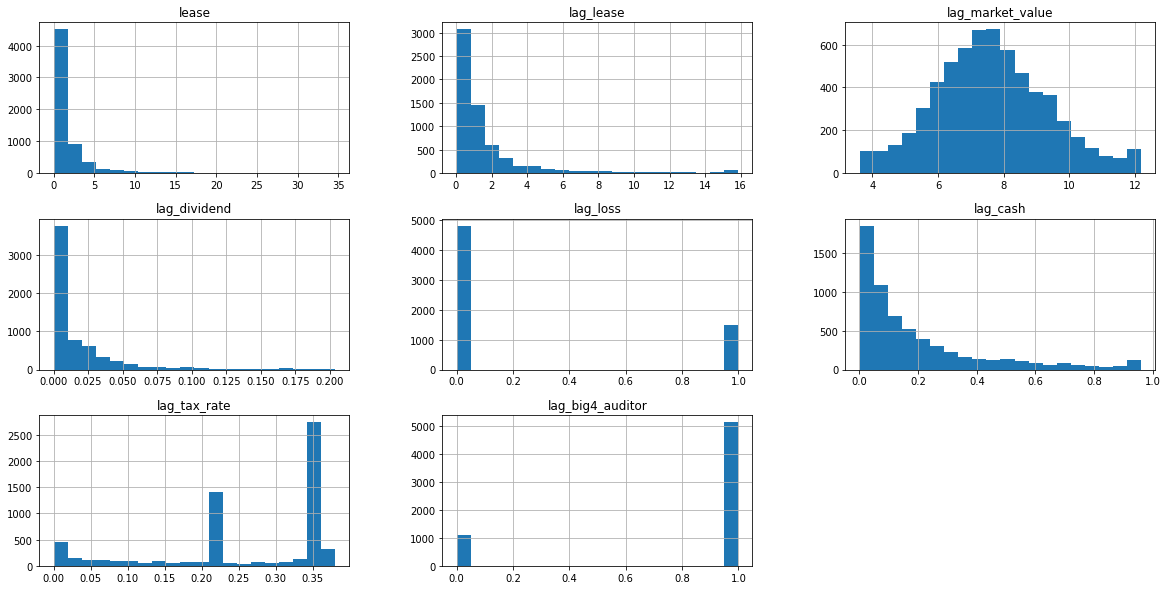

In [6]:
# Show histograms - all variables except for the identifier
sample_z = df.drop(columns='identifier')
sample_z.hist(bins = 20, figsize =(20, 10))
plt.show()



In [7]:

# Drop identifier, lag_loss, lag_big4_auditor, and lag_tax_rate 
var = ['identifier', 'lag_loss', 'lag_big4_auditor', 'lag_tax_rate']
sample_z = df.drop(columns=var)

In [8]:
# lag_loss and lag_big4_auditor are indicator variables and thus do not have outliers.

# Drop identifier, lag_loss, lag_big4_auditor, and lag_tax_rate 
var = ['identifier', 'lag_loss', 'lag_big4_auditor', 'lag_tax_rate']
sample_z = df.drop(columns=var)

In [9]:
# Create a function to report the limits of the Z-Score
def print_z_score_limits (df, column_name):
    """ Print the upper and lower limits of the Z-score """
    
    # Compute the limits
    upper_limit = df[column_name].mean() + 3 * df[column_name].std()
    lower_limit = df[column_name].mean() - 3 * df[column_name].std()
    
    # Round and return the limits
    upper_limit = round(upper_limit, 2)
    lower_limit = round(lower_limit, 2)
    print_this = "Variable Name: " + column_name + " | Upper limit: " + str(upper_limit) + " | Lower limit: " + str(lower_limit)
    return(print_this)


In [10]:
# Print the upper and lower limits
print_z_score_limits(sample_z, "lag_market_value")

'Variable Name: lag_market_value | Upper limit: 12.82 | Lower limit: 2.43'

In [11]:
# Filter outliers
sample_z = sample_z[(sample_z['lag_market_value'] >= 2.43) | (sample_z['lag_market_value'] <= 12.82)]
print(sample_z.shape)

(6279, 5)


In [12]:
# Drop lag_market_value
sample_z = sample_z.drop(columns=['lag_market_value'])

In [13]:
# Replace zeros with NaNs
sample_z['lag_dividend'] = sample_z['lag_dividend'].replace([0],np.NaN)
sample_z['lease'] = sample_z['lease'].replace([0],np.NaN)

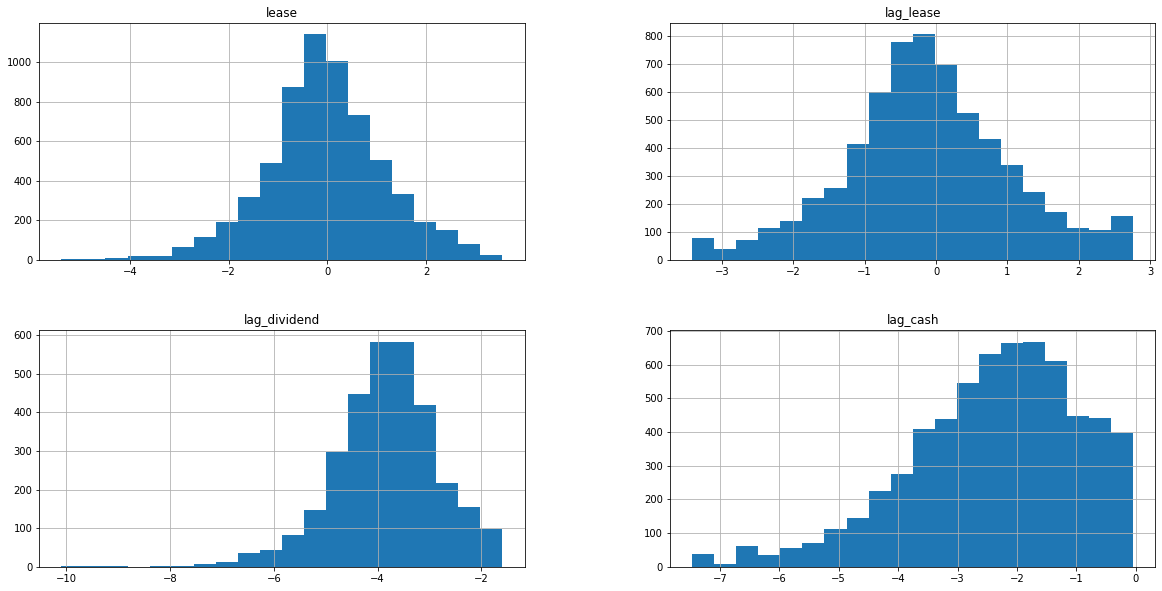

In [14]:
# Create a function to conduct log transformation
def log_transformation_function (df, column_name):
    """ Conduct a log transformation of a variable """
    # Replace the values with log-transformed values
    df[[column_name]] = df[[column_name]].apply(np.log)

# Conduct log transformation on all the variables
for column in sample_z:
    log_transformation_function(sample_z, column)   
    
# Plot histograms
sample_z.hist(bins = 20, figsize =(20, 10))
plt.show()


In [15]:
# Print the upper and lower limits
for column in sample_z:
    print(print_z_score_limits(sample_z, column))

Variable Name: lease | Upper limit: 3.55 | Lower limit: -3.64
Variable Name: lag_lease | Upper limit: 3.42 | Lower limit: -3.66
Variable Name: lag_dividend | Upper limit: -0.8 | Lower limit: -6.86
Variable Name: lag_cash | Upper limit: 1.97 | Lower limit: -6.76


In [16]:
# Print the maximum values
print("MAXIMUM VALUES")
print(round(sample_z.max(),2)) 

MAXIMUM VALUES
lease           3.54
lag_lease       2.76
lag_dividend   -1.59
lag_cash       -0.04
dtype: float64


In [17]:
#Isolation Forest - Multi-dimensional Outlier Detection

sample_isf = df.drop(columns='identifier')


In [18]:
# Conduct Principal Component Analysis (PCA)
# conduct PCA to reduce the firm feature dimensions from 7 to 2

# Standardize features
sample_scaled = StandardScaler().fit_transform(sample_isf)

# Define dimensions = 2
pca = PCA(n_components=2)       

# Conduct the PCA
principal_comp = pca.fit_transform(sample_scaled)     

# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
pca_df.head()


,principal_component_1,principal_component_2
0,-0.941123,-0.078371
1,-0.908097,0.062997
2,-0.984182,-0.140106
3,-0.352054,-0.265954
4,1.168329,-0.220572


In [19]:
# Train the model
isf = IsolationForest(contamination=0.04)
isf.fit(pca_df)

# Predictions
predictions = isf.predict(pca_df)



In [20]:
# Extract scores
pca_df["iso_forest_scores"] = isf.decision_function(pca_df)

# Extract predictions
pca_df["iso_forest_outliers"] = predictions

# Describe the dataframe
pca_df.describe()


,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
count,6.279000e+03,6.279000e+03,6279.000000,6279.000000
mean,1.012975e-16,-1.433972e-16,0.161289,0.919732
std,1.476402e+00,1.413903e+00,0.070087,0.392577
min,-3.451216e+00,-1.375379e+00,-0.155339,-1.000000
25%,-1.047614e+00,-7.105370e-01,0.131348,1.000000
50%,-3.918832e-01,-4.407937e-01,0.184288,1.000000
75%,6.940018e-01,9.532932e-02,0.213954,1.000000
max,4.864363e+00,1.051720e+01,0.235949,1.000000


In [21]:
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])

# Print the first 5 firms
pca_df.head()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,-0.941123,-0.078371,0.213461,No
1,-0.908097,0.062997,0.207519,No
2,-0.984182,-0.140106,0.208859,No
3,-0.352054,-0.265954,0.211116,No
4,1.168329,-0.220572,0.168660,No


In [22]:
# Add identifiers and cluster assignments (labels) to the sample
pca_df = pd.concat([df['identifier'], pca_df], axis=1)

# Print the first 5 firms
pca_df.head()

,identifier,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,1004,-0.941123,-0.078371,0.213461,No
1,1004,-0.908097,0.062997,0.207519,No
2,1004,-0.984182,-0.140106,0.208859,No
3,1004,-0.352054,-0.265954,0.211116,No
4,1050,1.168329,-0.220572,0.168660,No


In [23]:
# Export the sample as a csv file
pca_df.to_csv('outliers_detected.csv')